## Support vector machines

This exercise is described in [ex6.pdf](data/ml-ex6/ex6.pdf).

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from oct2py import octave
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC, LinearSVC

%matplotlib inline

### SVM with linear kernel

In [2]:
# Load dataset 1
data = sio.loadmat('data/ml-ex6/ex6data1.mat')

In [3]:
# Samples with features x1 and x2
X = data['X']
# Samples target class (0=neg, 1=pos)
y = data['y'].ravel()

In [4]:
def plot_data(X, y):
    '''Plots samples X and their class y in a 2D scatter plot.
    
    X must be an array of shape (m,2)
    y must be an array of shape (m,)
    '''
    
    plt.plot(X[y == 0,0], X[y == 0,1], 'yo', label='neg')
    plt.plot(X[y == 1,0], X[y == 1,1], 'b+', label='pos')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='lower left')
    
def plot_boundary(X, clf, level=0.0):
    '''Plots a decision boundary using trained classifier clf.
    
    The decision boundary is drawn at given level (default=0.0)
    in the range of X. X must be an array of shape (m,2).
    '''
    
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

    h = 0.01 # grid step size
    grid_x1, grid_x2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                                   np.arange(x2_min, x2_max, h))
    
    grid_y = clf.predict(np.c_[grid_x1.ravel(), grid_x2.ravel()])
    grid_y = grid_y.reshape(grid_x1.shape)

    x1_extra = (x1_max - x1_min) / 50
    x2_extra = (x2_max - x2_min) / 50
    
    plt.xlim(x1_min - x1_extra, x1_max + x1_extra)
    plt.ylim(x2_min - x2_extra, x2_max + x2_extra)
    
    plt.contour(grid_x1, grid_x2, grid_y, levels=[level])
    
def plot_support_vectors(clf):
    '''Plot the support vectors from trained support vector classifier clf.
    
    Only the support vectors of the first two classes are drawn.
    '''
    
    # Obtain support vectors for first two classes
    sv_neg, sv_pos = np.vsplit(clf.support_vectors_, np.cumsum(clf.n_support_)[0:1])

    # Plot support vectors
    plt.plot(sv_neg[:,0], sv_neg[:,1], 'r+', label='neg SVs', alpha=0.5)
    plt.plot(sv_pos[:,0], sv_pos[:,1], 'rx', label='pos SVs', alpha=0.5)
    plt.legend()

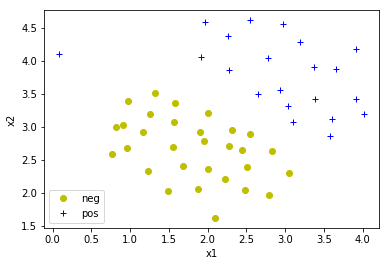

In [5]:
# Plot dataset 1
plot_data(X, y)

In [6]:
# Train a support vector classifier with C=1 using a linear kernel.
# SVC uses libsvm. For scaling to a large number of samples consider
# using LinearSVC which uses liblinear instead (see docs for details).
clf = SVC(C=1, kernel='linear') 
clf.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

C=1 misclassifies the outlier as shown in the following figure:

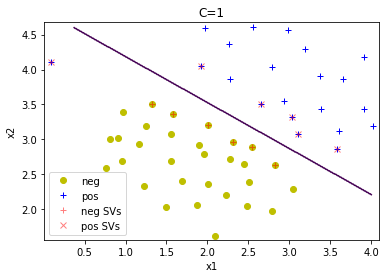

In [7]:
plot_data(X, y)
plot_boundary(X, clf)
plot_support_vectors(clf)
plt.title('C=1')

In [8]:
# Train a support vector classifier with C=100 using a linear kernel.
clf = SVC(C=100, kernel='linear')
clf.fit(X, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

C=100 correctly classifies the outlier as shown in the following figure (less regularization = higher variance, lower bias):

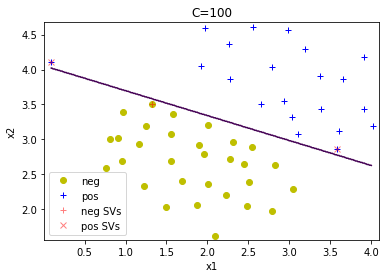

In [9]:
plot_data(X, y)
plot_boundary(X, clf)
plot_support_vectors(clf)
plt.title('C=100')

### SVM with Gaussian kernel

An [RBF kernel](http://scikit-learn.org/stable/modules/metrics.html#rbf-kernel) with gamma=1/sigma<sup>2</sup> is know as Gaussian kernel of variance sigma<sup>2</sup>.

In [10]:
# Load dataset 2
data = sio.loadmat('data/ml-ex6/ex6data2.mat')

In [11]:
# Samples with features x1 and x2
X = data['X']
# Samples target class (0=neg, 1=pos)
y = data['y'].ravel()

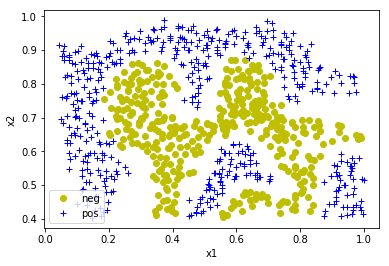

In [12]:
# Plot dataset 2
plot_data(X, y)

In [13]:
# Train a support vector classifier with C=1 using an RBF kernel.
# In ex6.m (original Octave exercise code), sigma=0.1, hence we
# set gamma to 100 (=1/sigma**2)
clf = SVC(C=1, kernel='rbf', gamma=100)
clf.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

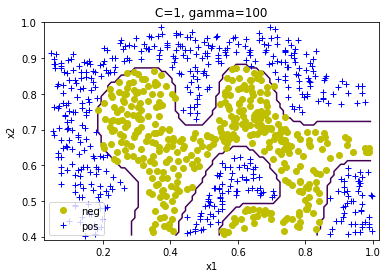

In [14]:
plot_data(X, y)
plot_boundary(X, clf)
plt.title('C=1, gamma=100')

In [15]:
# Load dataset 3
data = sio.loadmat('data/ml-ex6/ex6data3.mat')

# Training data 
X_train_0 = data['X']
y_train_0 = data['y'].ravel()

# Validation data
X_cv_0 = data['Xval']
y_cv_0 = data['yval'].ravel()

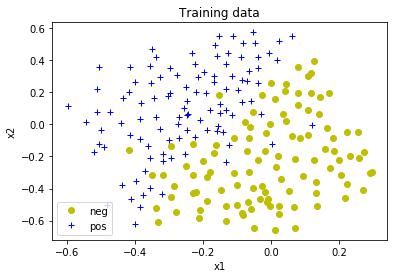

In [16]:
plot_data(X_train_0, y_train_0)
plt.title('Training data')

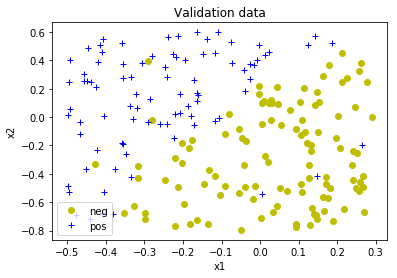

In [17]:
plot_data(X_cv_0, y_cv_0)
plt.title('Validation data')

In [18]:
# Concatenate training and validation data
X = np.concatenate([X_train_0, X_cv_0])
y = np.concatenate([y_train_0, y_cv_0])

num_train = X_train_0.shape[0]
num_cv = X_cv_0.shape[0]

# Create a cross validator that selects the pre-defined 
# validation dataset from the concatenated dataset.
cv_fold = np.empty(num_train + num_cv, dtype='int8')
cv_fold[:num_train] = -1
cv_fold[num_train:] = 0
cv = PredefinedSplit(cv_fold)

In [19]:
# Values for grid search (see description in ex6.pdf)
grid = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])

# Grid values for C
grid_C = grid
# Grid values for gamma
grid_gamma = 1 / (grid ** 2)

In [20]:
# Classifier used for grid search
clf = SVC(kernel='rbf')

# Grid search to find the best C and gamma values using the predefined
# training and validation set.
gs = GridSearchCV(clf, param_grid={'C':grid_C, 'gamma':grid_gamma}, cv=cv)
gs.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   3.00000e-02,   1.00000e-01,   3.00000e-01,
         1.00000e+00,   3.00000e+00,   1.00000e+01,   3.00000e+01]), 'gamma': array([  1.00000e+04,   1.11111e+03,   1.00000e+02,   1.11111e+01,
         1.00000e+00,   1.11111e-01,   1.00000e-02,   1.11111e-03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
# Display grid search results in a pandas DataFrame
pd.DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.003872,0.001880,0.435,0.502370,0.01,10000,"{'C': 0.01, 'gamma': 10000.0}",42,0.435,0.502370,0.0,0.0,0.0,0.0
1,0.003072,0.001746,0.435,0.502370,0.01,1111.11,"{'C': 0.01, 'gamma': 1111.11111111}",42,0.435,0.502370,0.0,0.0,0.0,0.0
2,0.003044,0.001766,0.435,0.502370,0.01,100,"{'C': 0.01, 'gamma': 100.0}",42,0.435,0.502370,0.0,0.0,0.0,0.0
3,0.003155,0.001521,0.435,0.502370,0.01,11.1111,"{'C': 0.01, 'gamma': 11.1111111111}",42,0.435,0.502370,0.0,0.0,0.0,0.0
4,0.001952,0.001278,0.435,0.502370,0.01,1,"{'C': 0.01, 'gamma': 1.0}",42,0.435,0.502370,0.0,0.0,0.0,0.0
5,0.002496,0.001414,0.435,0.502370,0.01,0.111111,"{'C': 0.01, 'gamma': 0.111111111111}",42,0.435,0.502370,0.0,0.0,0.0,0.0
6,0.001969,0.001275,0.435,0.502370,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",42,0.435,0.502370,0.0,0.0,0.0,0.0
7,0.001987,0.001479,0.435,0.502370,0.01,0.00111111,"{'C': 0.01, 'gamma': 0.00111111111111}",42,0.435,0.502370,0.0,0.0,0.0,0.0
8,0.002463,0.001579,0.435,0.502370,0.03,10000,"{'C': 0.03, 'gamma': 10000.0}",42,0.435,0.502370,0.0,0.0,0.0,0.0
9,0.002587,0.001685,0.435,0.502370,0.03,1111.11,"{'C': 0.03, 'gamma': 1111.11111111}",42,0.435,0.502370,0.0,0.0,0.0,0.0


In [22]:
# Obtain best classifier from grid search
clf_best = gs.best_estimator_

In [23]:
print('best C value =', clf_best.C)

best C value = 0.3


In [24]:
print('best gamma value =', clf_best.gamma)

best gamma value = 100.0


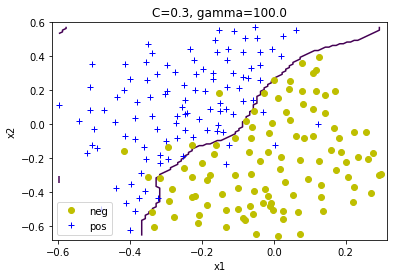

In [25]:
plot_data(X_train_0, y_train_0)
plot_boundary(X_train_0, clf_best)
plt.title(f'C={clf_best.C:.4}, gamma={clf_best.gamma:.4}')

### Spam classification

In [26]:
# Load spam classification training data
data_train = sio.loadmat('data/ml-ex6/spamTrain.mat')
# Load spam classification test data
data_test = sio.loadmat('data/ml-ex6/spamTest.mat')

In [27]:
# Sample feature vectors
X_train = data_train['X']
X_test = data_test['Xtest']

# Sample classes (0=non-spam, 1=spam)
y_train = data_train['y'].ravel()
y_test = data_test['ytest'].ravel()

In [28]:
# Train a linear SVC (running liblinear) using the 
# same value for C as in in the original exercise 
# (see ex6_spam.m)
clf = LinearSVC(C=0.1)
clf.fit(X_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [29]:
# Training score
clf.score(X_train, y_train)

0.99975000000000003

In [30]:
# Test score
clf.score(X_test, y_test)

0.99199999999999999

In [31]:
vocab = {}

# Read provided vocabulary from vocab.txt file and add 
# content to vocab, converting 1-based to 0-based index
with open('data/ml-ex6/vocab.txt') as vocab_file:
    for row in csv.reader(vocab_file, delimiter='\t'):
        word = row[1]
        index = int(row[0]) - 1
        vocab[word] = index

In [32]:
def read_file(file):
    with open(file) as f:
        return f.read()

# Read non-spam email samples
email_1 = read_file('data/ml-ex6/emailSample1.txt')
email_2 = read_file('data/ml-ex6/emailSample2.txt')

# Read spam email samples
spam_1 = read_file('data/ml-ex6/spamSample1.txt')
spam_2 = read_file('data/ml-ex6/spamSample2.txt')

In [33]:
# Print first 200 characters of a non-spam sample
print(email_1[:200], '...')

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should  ...


In [34]:
# Print first 200 characters of a spam sample
print(spam_1[:200], '...')

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NO ...


#### Email pre-processing

In the following, we reuse email pre-processing logic from the original course exercise and use [oct2py](http://blink1073.github.io/oct2py/index.html) for calling Octave functions from Python. The called function for email pre-processing is `processEmail` which is located in directory `func/ml-ex6/`. It is a modified version of the original function and returns pre-processed words instead of their index in the dictionary (to avoid sharing Octave code that must be written during assignments). For a more detailed description of `processEmail`, see [ex6.pdf](data/ml-ex6/ex6.pdf), section 2.1.

In [35]:
# Add directory func/ml-ex6 to Octave path.
# It contains file/function processEmail.m
octave.addpath('./func/ml-ex6');

In [36]:
# Pre-process emails with provided Octave code.
proc_email_1 = octave.processEmail(email_1)
proc_email_2 = octave.processEmail(email_2)
proc_spam_1 = octave.processEmail(spam_1)
proc_spam_1 = octave.processEmail(spam_1)

In [37]:
# Pre-processed non-spam sample
proc_email_1

array(['anyon     ', 'know      ', 'how       ', 'much      ',
       'it        ', 'cost      ', 'to        ', 'host      ',
       'a         ', 'web       ', 'portal    ', 'well      ',
       'it        ', 'depend    ', 'on        ', 'how       ',
       'mani      ', 'visitor   ', 'you       ', 're        ',
       'expect    ', 'thi       ', 'can       ', 'be        ',
       'anywher   ', 'from      ', 'less      ', 'than      ',
       'number    ', 'buck      ', 'a         ', 'month     ',
       'to        ', 'a         ', 'coupl     ', 'of        ',
       'dollarnumb', 'you       ', 'should    ', 'checkout  ',
       'httpaddr  ', 'or        ', 'perhap    ', 'amazon    ',
       'ecnumb    ', 'if        ', 'your      ', 'run       ',
       'someth    ', 'big       ', 'to        ', 'unsubscrib',
       'yourself  ', 'from      ', 'thi       ', 'mail      ',
       'list      ', 'send      ', 'an        ', 'email     ',
       'to        ', 'emailaddr '],
      dtype='<U10')

In [38]:
def words_to_features(words, vocab):
    '''Creates a feature vector from a list of words.
    
    The length of the returned feature vector is equal to 
    size of the vocabulary. The feature vector element i is 
    1 if the i-th word in the vocabulary is in the words list, 
    0 otherwise.
    '''
    
    features = np.zeros(len(vocab))
    for word in words:
        idx = vocab.get(word.strip())
        if idx:
            features[idx] = 1
    return features

In [39]:
# Convert pre-processed samples to feature vectors
X_samples = np.vstack([words_to_features(proc_email_1, vocab),
                       words_to_features(proc_email_2, vocab),
                       words_to_features(proc_spam_1, vocab),
                       words_to_features(proc_spam_1, vocab)])

In [40]:
# Predict the classes of samples (should be 
# [0, 0, 1, 1] where 0=non-spam and 1=spam)
clf.predict(X_samples)

array([0, 0, 1, 1], dtype=uint8)